In [69]:
from sympy.physics.mechanics import *
from sympy import symbols, trigsimp
from numpy import deg2rad, rad2deg, array, zeros, linspace, pi
from scipy.integrate import odeint
from sympy.functions.elementary.trigonometric import sin, cos
from sympy import Matrix
from sympy import ones
from sympy.vector import CoordSys3D, matrix_to_vector
from sympy import simplify
from sympy import expand
from sympy import symbols, solve
from sympy import ratsimp
from sympy import eye
import control
import numpy as np
from sympy.physics.vector import init_vprinting
import matplotlib.pyplot as plt

In [70]:
# Define state vector

# ZXY Euler angles: Roll Pitch Yaw Euler angles in inertial frame
theta, phi, psi = dynamicsymbols('theta phi psi') # drone orientation expressed in inertial frame
thetadot, phidot, psidot = dynamicsymbols('theta phi psi', 1) # drone angular velocity expressed in inertial frame



# X Y Z translation in inertial frame
x, y, z = dynamicsymbols('x y z')
xd, yd, zd = dynamicsymbols('x y z', 1)
# Generalized speeds (Body rates)
# Define the translation speeds in the inertial frame
# Define the rotational speeds in the body frame to simplify the process, otherwise the equations come out pretty ugly
# u1 = xd
# u2 = yd
# u3 = zd
u1, u2, u3, w1, w2, w3 = dynamicsymbols('u1 u2 u3 w1 w2 w3') # body rates
u1d, u2d, u3d, w1dot, w2dot, w3dot = dynamicsymbols('u1 u2 u3 w1 w2 w3', 1) # body ang accel


# Define Reference Frames
Nrf = ReferenceFrame('Nrf') # Inertial Reference Frame
# Body Fixed Reference Frame
# Z-X-Y Euler rotation, will write the DCM directly for sympy
cpsi = cos(psi)
spsi = sin(psi)
ctheta = cos(theta)
stheta = sin(theta)
cphi = cos(phi)
sphi = sin(phi)

c11 = cpsi*ctheta - sphi*spsi*stheta
c12 = -cphi*spsi
c13 = cpsi*stheta + ctheta*spsi*sphi
c21 = ctheta*spsi + cpsi*sphi*stheta
c22 = cphi*cpsi
c23 = spsi*stheta - cpsi*ctheta*sphi
c31 = -cphi*stheta
c32 = sphi
c33 = cphi*ctheta

BrfToNrf = Matrix([[c11, c12, c13],
                   [c21, c22, c23],
                   [c31, c32, c33]])

# Euler Kinematical Equations matrix
inertial2bodyrates = Matrix([[ctheta, 0, -cphi*stheta],
                             [0,      1,  sphi],
                             [stheta, 0,  cphi*ctheta]])

# Body frame is attached to CoM of drone
# b1 coincides with forward direction
# b3 is perpendicular ot plane of rotors pointing vertically up during hover
# body frame is parallel to principal axes
Brf = Nrf.orientnew('Brf', 'DCM', BrfToNrf)

# Set angular velocity of these frames
# Set angular velocity of Brf wrt to Nrf, express the angular velocity in the body frame i.e b_w_b/n
Brf.set_ang_vel(Nrf, w1*Brf.x + w2*Brf.y + w3*Brf.z)

# Define Locations
O = Point('O') # Inertial origin
O.set_vel(Nrf, 0)

# CoM of SC
d_CG = Point('d_CG')
# Set the CG position and velocity
# Express Position and Velocity in inertial frame
d_CG.set_pos(O, x*Nrf.x + y*Nrf.y + z*Nrf.z)
# Define using generalized speeds
d_CG.set_vel(Nrf, u1*Nrf.x + u2*Nrf.y + u3*Nrf.z)

# Gather everything into lists
# X Y Z translation
coordinates = [x, y, z, phi, theta, psi]
speeds = [u1, u2, u3, w1, w2, w3]

# Kinematic Differential Equations

# Kinematic relationship between inertial rates and body rates
# u4, u5, u6 are p, q r in the body frame
# The coordinates are in the inertial frame, so we need to convert the derivatives of the coordinates (theta, psi, phi) to the body frame
pqr_vec = inertial2bodyrates * Matrix([phidot, thetadot, psidot])

kde = [u1 - xd, u2 - yd, u3 - zd, w1 - pqr_vec[0], w2 - pqr_vec[1], w3 - pqr_vec[2]]


# initial kane's object
kane = KanesMethod(Nrf, q_ind=coordinates, u_ind=speeds, kd_eqs =kde)

# inertia dynamics
# inertia(N, 1, 2, 3, 4, 5, 6).to_matrix(N)
# Matrix([
#[1, 4, 6],
#[4, 2, 5],
#[6, 5, 3]])
I_x, I_y, I_z, I_xy, I_yz, I_zx, m_sc = symbols('I_X I_Y I_Z I_XY I_YZ I_ZX m_sc') # Inertia of drone and mass 
#itd = inertia(Brf, 1.43e-5, 1.43e-5, 2.89e-5, 0, 0, 0)
itd = inertia(Brf, I_x, I_y, I_z, I_xy, I_yz, I_zx)
#itd = inertia(Brf, I_x, I_y, I_z)

i1 = (itd, d_CG)
# Define rigid body objects
sc_body = RigidBody('sc_body', d_CG, Brf, m_sc, i1)

# Define forces and point of application
# Thrust and Torque from each motor 
M1, M2, M3 = dynamicsymbols('M1 M2 M3') # Make these dynamic as they can be time varying inputs


t_M1 = (Brf, M1*Brf.x)
t_M2 = (Brf, M2*Brf.y)
t_M3 = (Brf, M3*Brf.z)

loads = [t_M1, t_M2, t_M3]
bodies = [sc_body]

In [71]:
fr, frstar = kane.kanes_equations(bodies, loads)
eoms = fr + frstar
trigsimp(fr + frstar)


Matrix([
[                                                                                                                                                           -m_sc*Derivative(u1(t), t)],
[                                                                                                                                                           -m_sc*Derivative(u2(t), t)],
[                                                                                                                                                           -m_sc*Derivative(u3(t), t)],
[-I_X*Derivative(w1(t), t) - I_XY*Derivative(w2(t), t) - I_ZX*Derivative(w3(t), t) + (I_XY*w1(t) + I_Y*w2(t) + I_YZ*w3(t))*w3(t) - (I_YZ*w2(t) + I_Z*w3(t) + I_ZX*w1(t))*w2(t) + M1(t)],
[-I_XY*Derivative(w1(t), t) - I_Y*Derivative(w2(t), t) - I_YZ*Derivative(w3(t), t) - (I_X*w1(t) + I_XY*w2(t) + I_ZX*w3(t))*w3(t) + (I_YZ*w2(t) + I_Z*w3(t) + I_ZX*w1(t))*w1(t) + M2(t)],
[-I_YZ*Derivative(w2(t), t) - I_Z*Derivative(w3(t), t) - I_ZX*Deri

In [72]:
accel = solve(eoms, [u1d, u2d, u3d, w1dot, w2dot, w3dot])
simplify(accel[w1dot])


(-I_X*I_XY*I_YZ*w1(t)*w2(t) - I_X*I_XY*I_Z*w1(t)*w3(t) + I_X*I_Y*I_ZX*w1(t)*w2(t) + I_X*I_YZ*I_ZX*w1(t)*w3(t) + I_XY**2*I_YZ*w1(t)**2 - I_XY**2*I_YZ*w2(t)**2 - I_XY**2*I_Z*w2(t)*w3(t) + I_XY*I_Y*I_YZ*w1(t)*w2(t) - I_XY*I_Y*I_Z*w1(t)*w3(t) - I_XY*I_Y*I_ZX*w1(t)**2 + I_XY*I_Y*I_ZX*w2(t)**2 + 2*I_XY*I_YZ**2*w1(t)*w3(t) + I_XY*I_YZ*I_Z*w1(t)*w2(t) - I_XY*I_YZ*M3(t) + I_XY*I_Z**2*w1(t)*w3(t) + I_XY*I_Z*I_ZX*w1(t)**2 - I_XY*I_Z*I_ZX*w3(t)**2 + I_XY*I_Z*M2(t) - I_Y**2*I_Z*w2(t)*w3(t) - I_Y**2*I_ZX*w1(t)*w2(t) + I_Y*I_YZ**2*w2(t)*w3(t) + I_Y*I_YZ*I_Z*w2(t)**2 - I_Y*I_YZ*I_Z*w3(t)**2 - I_Y*I_YZ*I_ZX*w1(t)*w3(t) + I_Y*I_Z**2*w2(t)*w3(t) + I_Y*I_Z*I_ZX*w1(t)*w2(t) - I_Y*I_Z*M1(t) + I_Y*I_ZX**2*w2(t)*w3(t) + I_Y*I_ZX*M3(t) - I_YZ**3*w2(t)**2 + I_YZ**3*w3(t)**2 - I_YZ**2*I_Z*w2(t)*w3(t) - 2*I_YZ**2*I_ZX*w1(t)*w2(t) + I_YZ**2*M1(t) - I_YZ*I_Z*I_ZX*w1(t)*w3(t) - I_YZ*I_ZX**2*w1(t)**2 + I_YZ*I_ZX**2*w3(t)**2 - I_YZ*I_ZX*M2(t))/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2)

In [73]:
# Rigid Body Equations of Motion 
w = Matrix([w1, w2, w3])
T = Matrix([M1, M2, M3])
Iw = itd.to_matrix(Brf) * w
w_dot_truth =  itd.to_matrix(Brf).inv()*(T - w.cross(Iw))
simplify(w_dot_truth[0])



(-(I_XY*I_YZ - I_Y*I_ZX)*((I_X*w1(t) + I_XY*w2(t) + I_ZX*w3(t))*w2(t) - (I_XY*w1(t) + I_Y*w2(t) + I_YZ*w3(t))*w1(t) + M3(t)) + (I_XY*I_Z - I_YZ*I_ZX)*(-(I_X*w1(t) + I_XY*w2(t) + I_ZX*w3(t))*w3(t) + (I_YZ*w2(t) + I_Z*w3(t) + I_ZX*w1(t))*w1(t) + M2(t)) - (I_Y*I_Z - I_YZ**2)*((I_XY*w1(t) + I_Y*w2(t) + I_YZ*w3(t))*w3(t) - (I_YZ*w2(t) + I_Z*w3(t) + I_ZX*w1(t))*w2(t) + M1(t)))/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2)

In [74]:
kane_ver = simplify(accel[w1dot])
manual_ver = simplify(w_dot_truth[0])

print(expand(kane_ver))
print(expand(manual_ver))

print(expand(kane_ver) == expand(manual_ver))
# Confirmed matches up :D 

-I_X*I_XY*I_YZ*w1(t)*w2(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) - I_X*I_XY*I_Z*w1(t)*w3(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) + I_X*I_Y*I_ZX*w1(t)*w2(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) + I_X*I_YZ*I_ZX*w1(t)*w3(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) + I_XY**2*I_YZ*w1(t)**2/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) - I_XY**2*I_YZ*w2(t)**2/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) - I_XY**2*I_Z*w2(t)*w3(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) + I_XY*I_Y*I_YZ*w1(t)*w2(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) - I_XY*I_Y*I_Z*w1(t)*w3(t)/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_YZ*I_ZX + I_Y*I_ZX**2) - I_XY*I_Y*I_ZX*w1(t)**2/(-I_X*I_Y*I_Z + I_X*I_YZ**2 + I_XY**2*I_Z - 2*I_XY*I_

In [75]:
# linearize(op_point=None, A_and_B=False, simplify=False)
x0, y0, z0 = symbols('x0 y0 z0')
w_x_s = symbols('w_s') # Linearize about spin rate

op_point = {
    x: 0,
    y: 0,
    z: 0,
    phidot: 0,
    thetadot: 0,
    psidot: 0,
    w1: w_x_s,
    w2: 0,
    w3: 0,
    theta: 0,
    phi: 0,
    psi: 0,
    u1: 0,
    u2: 0,
    u3: 0,
    M1: 0,
    t_M1: 0,
}
# oordinates = [x, y, z, phi, theta, psi]
# speeds = [u1, u2, u3, u4, u5, u6]
linearizer  = kane.to_linearizer()
linearizer.r = Matrix([M1, M2, M3]) # can use to reorganize inputs
A, B = linearizer.linearize(A_and_B=True, op_point=[op_point], simplify = True)

trigsimp(A*Matrix([linearizer.q, linearizer.u]))

trigsimp(B*linearizer.r)

eoms = trigsimp(A*Matrix([linearizer.q, linearizer.u]) + B*linearizer.r)
simplify(eoms)
# x_dot = Ax+B
#x_dot = A*Matrix([linearizer.q, linearizer.u]) + B*linearizer.r





Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      u1(t)],
[                                                                                                                                                                                                                                                                               

In [76]:
# Symbolic transfer function
A_att = A[9:, 9:]
B_att = B[9:, :]
s = symbols('s')
C = Matrix([1, 0, 0]).transpose()

I = eye(A_att.shape[0])

G_s = simplify(C * (s * I - A_att).inv() * B_att)

G_s[0]

(I_X**2*w_s**2 - I_X*I_Y*w_s**2 - I_X*I_Z*w_s**2 + I_Y*I_Z*s**2 + I_Y*I_Z*w_s**2 - I_YZ**2*s**2 - I_YZ**2*w_s**2)/(I_X**3*s*w_s**2 - I_X**2*I_Y*s*w_s**2 - I_X**2*I_Z*s*w_s**2 + 3*I_X*I_XY**2*s*w_s**2 + I_X*I_Y*I_Z*s**3 + I_X*I_Y*I_Z*s*w_s**2 - I_X*I_YZ**2*s**3 - I_X*I_YZ**2*s*w_s**2 + 3*I_X*I_ZX**2*s*w_s**2 + I_XY**2*I_Y*s*w_s**2 - 2*I_XY**2*I_YZ*w_s**3 - I_XY**2*I_Z*s**3 - 2*I_XY**2*I_Z*s*w_s**2 + 2*I_XY*I_Y*I_ZX*w_s**3 + 2*I_XY*I_YZ*I_ZX*s**3 + 6*I_XY*I_YZ*I_ZX*s*w_s**2 - 2*I_XY*I_Z*I_ZX*w_s**3 - I_Y*I_ZX**2*s**3 - 2*I_Y*I_ZX**2*s*w_s**2 + 2*I_YZ*I_ZX**2*w_s**3 + I_Z*I_ZX**2*s*w_s**2)

In [77]:
B_att

Matrix([
[    (I_Y*I_Z - I_YZ**2)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2), (-I_XY*I_Z + I_YZ*I_ZX)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2),  (I_XY*I_YZ - I_Y*I_ZX)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2)],
[(-I_XY*I_Z + I_YZ*I_ZX)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2),     (I_X*I_Z - I_ZX**2)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2), (-I_X*I_YZ + I_XY*I_ZX)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2)],
[ (I_XY*I_YZ - I_Y*I_ZX)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2), (-I_X*I_YZ + I_XY*I_ZX)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2),     (I_X*I_Y - I_XY**2)/(I_X*I_Y*I_Z - I_X*I_YZ**2 - I_XY**2*I_Z + 2*I_XY*I_YZ*I_ZX - I_Y*I_ZX**2)]])

In [78]:
# Sub mass properties in and create linear model to use for controls
I_SC = np.array([
            [2402.52, 36.33, 78.17],
            [36.33, 2072.58, -67.71],
            [78.17, -67.71, 2022.10]
        ])
spin_rate = np.deg2rad(1.0)
A_numeric = A_att.subs({I_x: I_SC[0,0], I_y: I_SC[1,1], I_z: I_SC[2,2], I_xy: I_SC[0,1], I_yz: I_SC[1,2], I_zx: I_SC[0,2], w_x_s: spin_rate}).evalf()
B_numeric = B_att.subs({I_x: I_SC[0,0], I_y: I_SC[1,1], I_z: I_SC[2,2], I_xy: I_SC[0,1], I_yz: I_SC[1,2], I_zx: I_SC[0,2], w_x_s: spin_rate}).evalf()

# Convert SymPy matrices to NumPy arrays
A_np = np.array(A_numeric.tolist(), dtype=float)
B_np = np.array(B_numeric.tolist(), dtype=float)



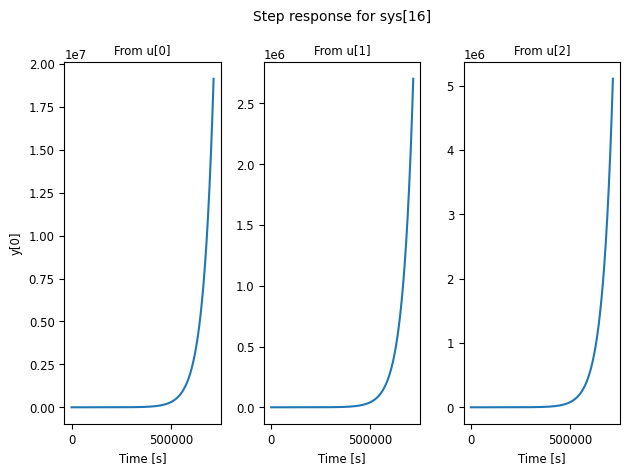

In [85]:

# Define state-space system
C_np = np.array([1, 0, 0])
D_np = np.array([0,0,0])
sys = control.ss(A_np, B_np, C_np, D_np)

# Convert to transfer function

response = control.step_response(sys)
response.plot()

In [101]:
B_y = B_np[:, 1]
D_y = 0
C_y = np.array([0, 1, 0])
sys_y = control.ss(A_np, B_y, C_y, D_y)

control.ss2tf(sys_y)

TransferFunction(array([ 4.83166351e-04, -2.87665097e-07,  8.00735651e-11]), array([ 1.00000000e+00, -7.25060203e-19,  9.93027685e-06, -1.91671458e-10]))

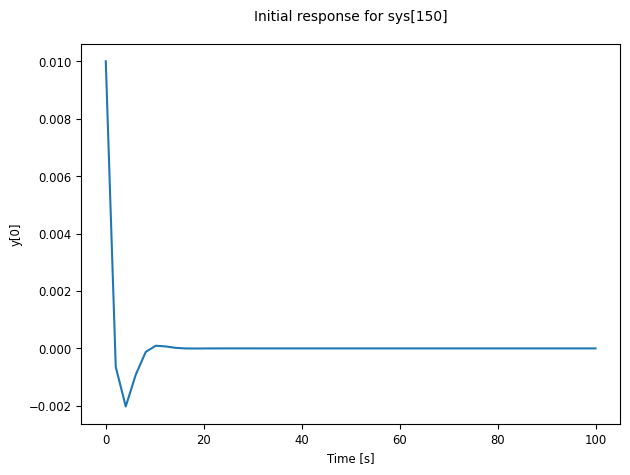

In [139]:
#tf = control.ss2tf(sys
#kp = np.array([1500.0, 1800.0, 1800.0])
kp = 1800
ki = 800 
#ki = np.array([800.0, 800.0, 800.0])
control_tf_y = control.TransferFunction(
    [kp, ki], [1, 0])
sys_fd_y = control.feedback(sys_y, control_tf_y)
T = np.linspace(0, 100)
X0 = np.array([0.01, 0.01, 0.01, 0])
response_cl = control.initial_response(sys_fd_y, T, X0 = X0)
response_cl.plot()

Gain Margin:  inf
Phase Margin:  90.0026232838286


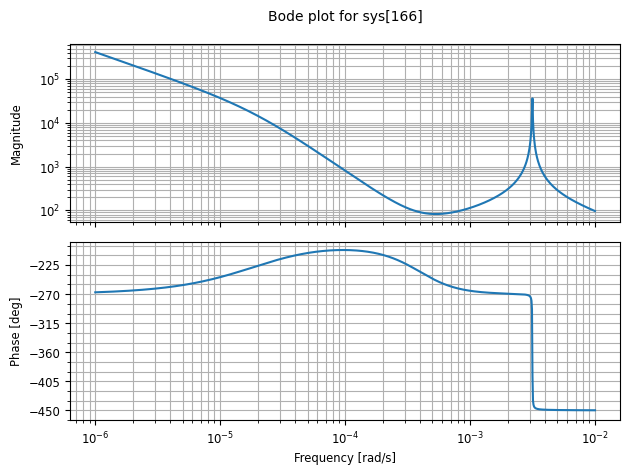

In [144]:
sys_ol_y = sys_y*control_tf
gm, pm, wcg, wcp = control.margin(sys_ol_y)
print("Gain Margin: ", gm)
print("Phase Margin: ", pm)

control.bode_plot(sys_ol_y)

In [ ]:
# X-axis
B_x = B_np[:, 0]
D_x = 0
C_x = np.array([1, 0, 0])
sys_x = control.ss(A_np, B_x, C_x, D_x)

control.ss2tf(sys_x)

#tf = control.ss2tf(sys
#kp = np.array([1500.0, 1800.0, 1800.0])
kp = 1500
ki = 800 
#ki = np.array([800.0, 800.0, 800.0])
control_tf_x = control.TransferFunction(
    [kp, ki], [1, 0])
sys_fd_x = control.feedback(sys_x, control_tf_x)
T = np.linspace(0, 100)
X0 = np.array([0.01, 0.01, 0.01, 0])
response_cl = control.initial_response(sys_fd_x, T, X0 = X0)
response_cl.plot()

sys_ol_x = sys_x*control_tf_x
gm, pm, wcg, wcp = control.margin(sys_ol_x)
print("Gain Margin: ", gm)
print("Phase Margin: ", pm)

control.bode_plot(sys_ol_x)